In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Github

https://github.com/cfildish/CU_AI/tree/main/CSCA_5642_Deep_Learning/CNN_Cancer_Detection

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Used for EDA
from PIL import Image

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import img_to_array, load_img
import keras


# Problem and Data Description

The goal of this problem is to identify metastatic tissue in histopathologic scans of lymph node sections. Given images of scans the goal is to identify the scans as positive or negative.

The images have dimension 96x96x3 which is about 27,648 predictors for each image. There are a total of about 220,000 train images with known labels and 57,458 test images.

Given the limitations of using the free version of Google Colab and Google Drive, we limit the train dataset size for modeling below to 20,000 train images to allow for quicker model tuning and optimization.

# Ingest Data

### Pre-process Data Into CSVs for Google Drive (run locally)

Steps for preprocessing. For every 1000 images:
1. Flatten each of the images from (96,96,3) to (,27648)
2. Append 1000 images to create (1000,27648) array
3. In the case of train images, append the label of the image to the last column
4. Write array to csv and upload to Google Drive

#### Test

In [ ]:
first_img = True
cnt = 0
import sys

for file in glob.glob(f'/Desktop/histopathologic-cancer-detection/test/*.tif'):
    if cnt % 1000 == 0 and cnt != 0:
        np.savetxt(f"/Desktop/test/test_{cnt}.csv", merged_arr, delimiter=",")
        np.savetxt(f"/Desktop/test/test_labels_{cnt}.csv", file_names, delimiter=",", fmt='%s')
        first_img = True
        print(f"{round(cnt/57500,2)*100}% Complete")
    img = Image.open(file)
    img_arr = np.asarray(img).reshape(-1)
    img_arr = np.array([list(img_arr)])
    if first_img:
        file_names = np.array([file.split("/")[-1].split(".")[0]])
        merged_arr = img_arr
        first_img = False
    else:
        file_names = np.append(file_names, file.split("/")[-1].split(".")[0])
        merged_arr = np.append(merged_arr, img_arr, axis=0)

    cnt+=1

np.savetxt(f"/Desktop/test/test_{cnt}.csv", merged_arr, delimiter=",")
np.savetxt(f"/Desktop/test/test_labels_{cnt}.csv", file_names, delimiter=",", fmt='%s')


#### Train

In [ ]:
first_img = True
cnt = 0
import sys

for file in glob.glob(f'/Desktop/histopathologic-cancer-detection/test/*.tif'):
    if cnt % 1000 == 0 and cnt != 0:
        np.savetxt(f"/Desktop/test/test_{cnt}.csv", merged_arr, delimiter=",")
        np.savetxt(f"/Desktop/test/test_labels_{cnt}.csv", file_names, delimiter=",", fmt='%s')
        first_img = True
        print(f"{round(cnt/57500,2)*100}% Complete")
    img = Image.open(file)
    img_arr = np.asarray(img).reshape(-1)
    img_arr = np.array([list(img_arr)])
    if first_img:
        file_names = np.array([file.split("/")[-1].split(".")[0]])
        merged_arr = img_arr
        first_img = False
    else:
        file_names = np.append(file_names, file.split("/")[-1].split(".")[0])
        merged_arr = np.append(merged_arr, img_arr, axis=0)

    cnt+=1

np.savetxt(f"/Desktop/test/test_{cnt}.csv", merged_arr, delimiter=",")
np.savetxt(f"/Desktop/test/test_labels_{cnt}.csv", file_names, delimiter=",", fmt='%s')


The training and test data were pre-prepared locally into csvs to upload into Google Drive (see the code from the local notebook above). X and y are generated from the train csvs.

In this case, we generate train and test data from the train dataset because the labels are known so we're able to monitor the train and test accuracies during each epoch of the CNN. Then once an optimal model architecture and hyperparameters are determined, the optimal model is used to predict the labels for the test dataset and create the submission for Kaggle.

In [ ]:
train_file_path = "/content/drive/MyDrive/Colab Notebooks/histopathologic-cancer-detection-data/train/*.csv"

first_df = True
for file in glob.glob(train_file_path):
  df = pd.read_csv(file, header=None)
  label = df.iloc[:, -1]
  df = df.iloc[:, :-1]
  if first_df:
    X = df
    y = label
    first_df = False
  else:
    X = pd.concat([X, df])
    y = pd.concat([y, label])

X.head()


,0,1,2,3,4,5,6,7,8,9,...,27638,27639,27640,27641,27642,27643,27644,27645,27646,27647
0,246.0,246.0,244.0,247.0,247.0,245.0,249.0,248.0,246.0,250.0,...,244.0,245.0,245.0,243.0,243.0,243.0,241.0,242.0,242.0,240.0
1,251.0,247.0,246.0,253.0,248.0,245.0,243.0,238.0,235.0,244.0,...,199.0,243.0,222.0,227.0,253.0,237.0,240.0,255.0,246.0,248.0
2,255.0,236.0,255.0,126.0,88.0,129.0,122.0,85.0,126.0,63.0,...,241.0,255.0,239.0,255.0,198.0,175.0,185.0,197.0,177.0,179.0
3,134.0,75.0,169.0,164.0,102.0,188.0,195.0,128.0,205.0,187.0,...,199.0,146.0,91.0,174.0,136.0,76.0,162.0,141.0,77.0,164.0
4,93.0,23.0,47.0,147.0,88.0,120.0,64.0,19.0,62.0,71.0,...,71.0,68.0,28.0,65.0,77.0,29.0,77.0,84.0,26.0,84.0


Convert the entries in each dataframes to an int because data is being read from csv as a float

In [ ]:
X = X.astype("int")
y = y.astype("int")


Convert X and y back into arrays

In [ ]:
X = X.to_numpy()
y = y.to_numpy()


Split train dataset into test and train to allow for monitoring of the train and test accuracy over the course of the CNN fit.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# EDA

In terms of data cleaning, no features are dropped prior to modeling and there are no NA values that need to be addressed because the feaures are pixel values. A subset of the original training data is used to allow for quicker hyperparameter tuning with the free version of Google Colab.

I also split the data into and test and training subset and will plan on monitoring both the test and train accuracy during epochs to try to optimize the amount of epochs in addition to the other hyperparameters I'll try to tune with the CNN model.

## Distribution of Classes in Train Subset used for Modeling

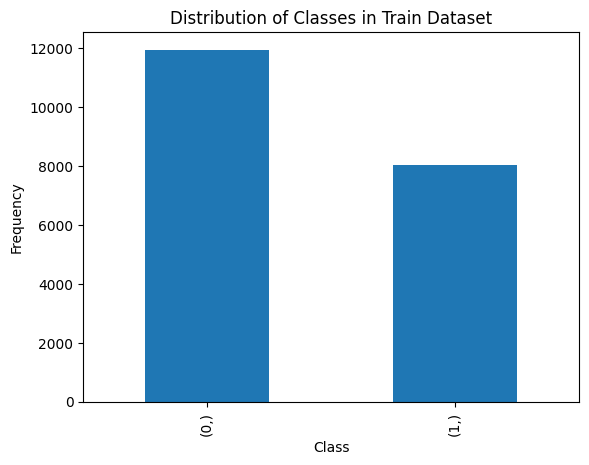

In [ ]:
y_df = pd.DataFrame(y)

plt.figure()
y_df.value_counts().plot(kind="bar")
plt.title("Distribution of Classes in Train Dataset")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()


## Example Images for Negative Class

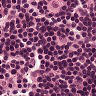

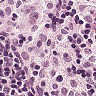

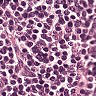

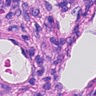

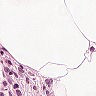

In [ ]:
negative_file_path = "/content/drive/MyDrive/Colab Notebooks/CNN_Cancer_Detection/example_images/negative/*.tif"

for img in glob.glob(negative_file_path):
  im = Image.open(img)
  display(im)
  print()

## Examples Images for Positive Class

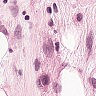

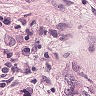

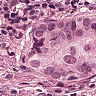

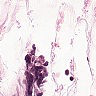

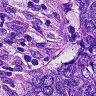

In [ ]:
negative_file_path = "/content/drive/MyDrive/Colab Notebooks/CNN_Cancer_Detection/example_images/positive/*.tif"

for img in glob.glob(negative_file_path):
  im = Image.open(img)
  display(im)
  print()


## Average image for train dataset

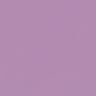

In [ ]:
avg_arr=np.zeros((96,96,3),float)
N=len(X)

for im in X:
  imarr=im.reshape(96,96,3)
  avg_arr=avg_arr+imarr/N

avg_arr=np.array(np.round(avg_arr),dtype=np.uint8)
# Generate, save and preview final image
out=Image.fromarray(avg_arr)
out.save("/content/drive/MyDrive/Colab Notebooks/avg_train.png")
out

The average image for the train data set is monochromatic because of the high volume of images that are used for modeling. This likely would be the case for the test dataset as well, so it doesn't provide much explanatory value.

Based on the EDA above, the train data is split about 60/40 in terms of the different classes- if I have time, one thing I could try to improve the train subset further is to ensure the subset is split evenly between the two classes.

My plan of analysis is to start by using a certain number of layers of the Conv2d -> Conv2d -> MaxPooling recommended in the class videos, and ensure the outer layer uses sigmoid because of the binary classification (can also look into tanh if I have time)

# Model Architecture

In terms of modeling I'm starting with a sequential CNN with 3 "Conv2d -> Conv2d -> MaxPooling" layers, a flattening layer, dense layer, and output layer. All activations prior to the output layer use relu activation and the output layer utilizes sigmoid because the output is expected to be binary. For the first model I'm starting with the default hyperparameters and will tune things based on how the first model performs from a test and train perspective.

In [ ]:


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(96, 96, 3)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 92, 92, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 44, 44, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 42, 42, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 21, 21, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 19, 19, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 17, 17, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,361 (2.10 MB)

 Trainable params: 549,361 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adamax(),
              metrics=['acc'])


In [ ]:
X_train = X_train.reshape(-1, 96, 96, 3)
X_test = X_test.reshape(-1, 96, 96, 3)

In [ ]:
class TestSetEvaluation(keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        super().__init__()
        self.x_test = x_test
        self.y_test = y_test
        self.test_loss = []
        self.test_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        self.test_loss.append(loss)
        self.test_accuracy.append(accuracy)
        print(f"\nEpoch {epoch+1}: Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

test_eval_callback = TestSetEvaluation(X_test, y_test)


In [ ]:
model.fit(X_train, y_train, epochs=30, callbacks=[test_eval_callback])


Epoch 1/30
493/500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.6247 - loss: 1.5020
Epoch 1: Test Loss: 0.4985, Test Accuracy: 0.7582
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - acc: 0.6259 - loss: 1.4896
Epoch 2/30
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7695 - loss: 0.4874
Epoch 2: Test Loss: 0.4625, Test Accuracy: 0.7868
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - acc: 0.7695 - loss: 0.4874
Epoch 3/30
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7863 - loss: 0.4585
Epoch 3: Test Loss: 0.5063, Test Accuracy: 0.7565
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - acc: 0.7863 - loss: 0.4585
Epoch 4/30
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7860 - loss: 0.4537
Epoch 4: Test Loss: 0.4784, Test Accuracy: 0.7742
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - acc: 0.7860 - loss: 0.4537
Epoch 5/30
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7984 - loss: 0.4381
Epoch 5: Test Loss: 0.4521, Test Accuracy: 0.7937
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - acc: 0.7984 - lo

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/cnn_model_1.keras')

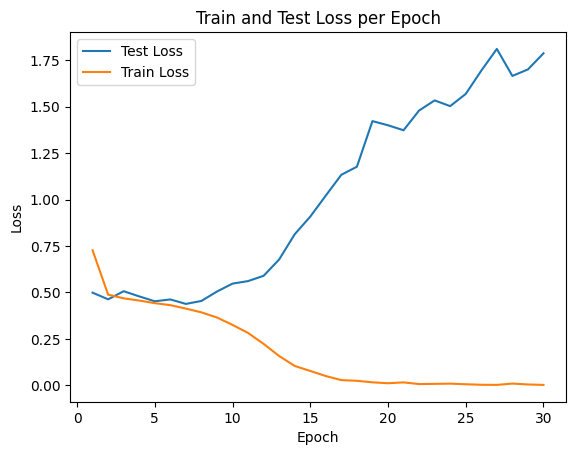

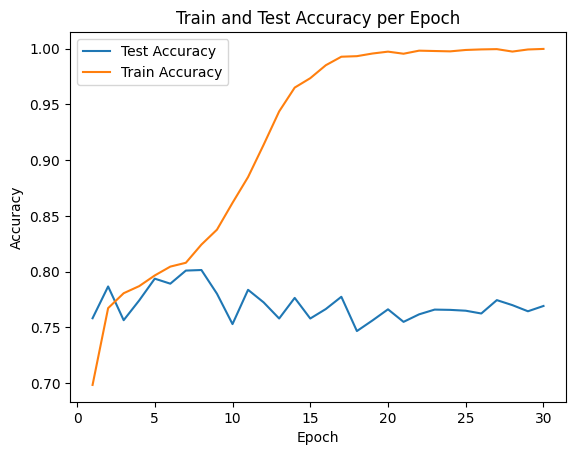

In [ ]:
plot_df = pd.DataFrame({'Test Loss': test_eval_callback.test_loss, 'Test Accuracy': test_eval_callback.test_accuracy,
                        'Train Loss': model.history.history['loss'], 'Train Accuracy': model.history.history['acc'],
                        'Epoch': range(1, len(test_eval_callback.test_loss) + 1)})

plt.figure()
plt.plot(plot_df["Epoch"], plot_df["Test Loss"], label="Test Loss")
plt.plot(plot_df["Epoch"], plot_df["Train Loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss per Epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(plot_df["Epoch"], plot_df["Test Accuracy"], label="Test Accuracy")
plt.plot(plot_df["Epoch"], plot_df["Train Accuracy"], label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy per Epoch")
plt.legend()
plt.show()


Looking at the train and test accuracy per epoch below, it looks like there's a severe case of overfitting in the first model based on the seperation between the train and test accuracy and the train and test losss. The test loss never really improves with epochs in the first model

# Results and Analysis

## Model Tuning 1 - Introduce Batch Normalization to Address Overfitting

The first thing I do to address overfitting is to introduce a batch normalization layer after each of the "Conv2d -> Conv2d -> MaxPooling" layer.

In [ ]:
model_bn = models.Sequential()
model_bn.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(96, 96, 3)))
model_bn.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_bn.add(layers.MaxPooling2D((2, 2)))
model_bn.add(layers.BatchNormalization())
model_bn.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_bn.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_bn.add(layers.MaxPooling2D((2, 2)))
model_bn.add(layers.BatchNormalization())
model_bn.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_bn.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_bn.add(layers.MaxPooling2D((2, 2)))
model_bn.add(layers.BatchNormalization())
model_bn.add(layers.Flatten())
model_bn.add(layers.Dense(512, activation='relu'))
model_bn.add(layers.Dense(1, activation='sigmoid'))

model_bn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 92, 92, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 46, 46, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 46, 46, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 44, 44, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 42, 42, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 21, 21, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 21, 21, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 19, 19, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 17, 17, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,553 (2.10 MB)

 Trainable params: 549,457 (2.10 MB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
model_bn.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adamax(),
              metrics=['acc'])


In [ ]:
test_eval_callback = TestSetEvaluation(X_test, y_test)
model_bn.fit(X_train, y_train, epochs=20, callbacks=[test_eval_callback])


Epoch 1/20
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7562 - loss: 0.5428
Epoch 1: Test Loss: 1.6647, Test Accuracy: 0.6043
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - acc: 0.7564 - loss: 0.5423
Epoch 2/20
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8225 - loss: 0.4042
Epoch 2: Test Loss: 0.6632, Test Accuracy: 0.7115
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - acc: 0.8225 - loss: 0.4042
Epoch 3/20
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8351 - loss: 0.3679
Epoch 3: Test Loss: 1.1574, Test Accuracy: 0.6532
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - acc: 0.8352 - loss: 0.3680
Epoch 4/20
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8631 - loss: 0.3213
Epoch 4: Test Loss: 0.6141, Test Accuracy: 0.7513
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.8630 - loss: 0.3214
Epoch 5/20
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8848 - loss: 0.2815
Epoch 5: Test Loss: 0.5748, Test Accuracy: 0.7237
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - acc: 0.8848 - los

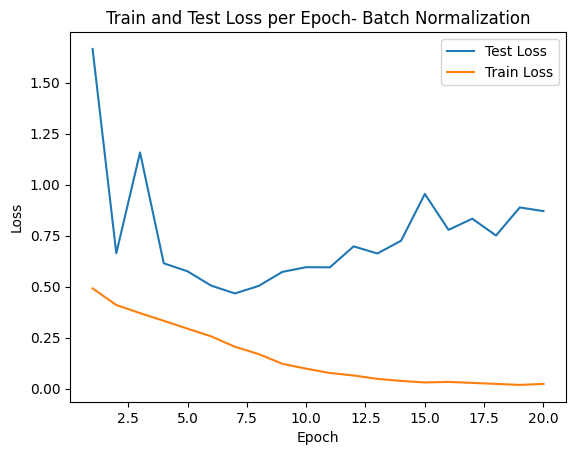

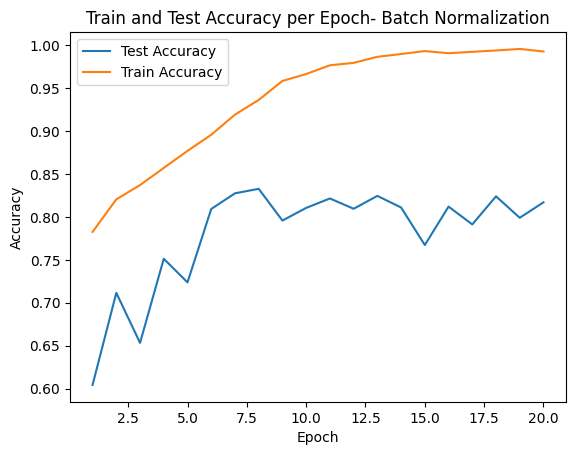

In [ ]:
plot_df = pd.DataFrame({'Test Loss': test_eval_callback.test_loss, 'Test Accuracy': test_eval_callback.test_accuracy,
                        'Train Loss': model_bn.history.history['loss'], 'Train Accuracy': model_bn.history.history['acc'],
                        'Epoch': range(1, len(test_eval_callback.test_loss) + 1)})

plt.figure()
plt.plot(plot_df["Epoch"], plot_df["Test Loss"], label="Test Loss")
plt.plot(plot_df["Epoch"], plot_df["Train Loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss per Epoch- Batch Normalization")
plt.legend()
plt.show()

plt.figure()
plt.plot(plot_df["Epoch"], plot_df["Test Accuracy"], label="Test Accuracy")
plt.plot(plot_df["Epoch"], plot_df["Train Accuracy"], label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy per Epoch- Batch Normalization")
plt.legend()
plt.show()

This time the test accuracy improves over time with epochs which is an imporovement to the first model. However, the distance between the train and test loss and accuracies still suggest that there is some overfitting and there could be room for improvement. The test accuracy and loss seems to hit an optimal point before 20 epochs as well.

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/cnn_model_bn.keras')


## Model Tuning 2 - Add Drop Layers to Further Reduce Overfitting

To further address overfitting, in addition to the batch normalization layers introduced in the first model tuning above, we add a dropout layer before the dense layers with it set to drop 20% of the inputs.

In [ ]:
model_dropout = models.Sequential()
model_dropout.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(96, 96, 3)))
model_dropout.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_dropout.add(layers.MaxPooling2D((2, 2)))
model_dropout.add(layers.BatchNormalization())
model_dropout.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_dropout.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_dropout.add(layers.MaxPooling2D((2, 2)))
model_dropout.add(layers.BatchNormalization())
model_dropout.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_dropout.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_dropout.add(layers.MaxPooling2D((2, 2)))
model_dropout.add(layers.BatchNormalization())
model_dropout.add(layers.Dropout(0.2))
model_dropout.add(layers.Flatten())
model_dropout.add(layers.Dense(512, activation='relu'))
model_dropout.add(layers.Dense(1, activation='sigmoid'))

model_dropout.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 92, 92, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 46, 46, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 46, 46, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 44, 44, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 42, 42, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 21, 21, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 21, 21, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 19, 19, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 17, 17, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,553 (2.10 MB)

 Trainable params: 549,457 (2.10 MB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
model_dropout.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adamax(),
              metrics=['acc'])

In [ ]:
test_eval_callback = TestSetEvaluation(X_test, y_test)
model_dropout.fit(X_train, y_train, epochs=20, callbacks=[test_eval_callback])


Epoch 1/20
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7502 - loss: 0.5485
Epoch 1: Test Loss: 0.9165, Test Accuracy: 0.6760
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - acc: 0.7505 - loss: 0.5480
Epoch 2/20
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8103 - loss: 0.4319
Epoch 2: Test Loss: 1.0281, Test Accuracy: 0.6530
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - acc: 0.8103 - loss: 0.4318
Epoch 3/20
496/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8302 - loss: 0.3904
Epoch 3: Test Loss: 0.5498, Test Accuracy: 0.7915
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.8302 - loss: 0.3904
Epoch 4/20
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8400 - loss: 0.3730
Epoch 4: Test Loss: 0.6783, Test Accuracy: 0.7275
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.8400 - loss: 0.3730
Epoch 5/20
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8643 - loss: 0.3198
Epoch 5: Test Loss: 0.4382, Test Accuracy: 0.8177
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.8642 - lo

0.42464515566825867


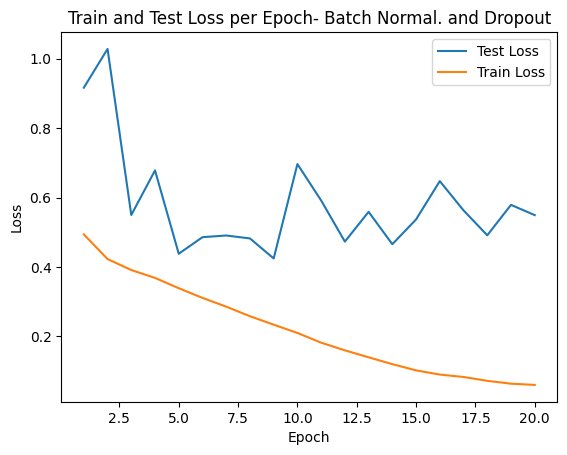

0.8432499766349792


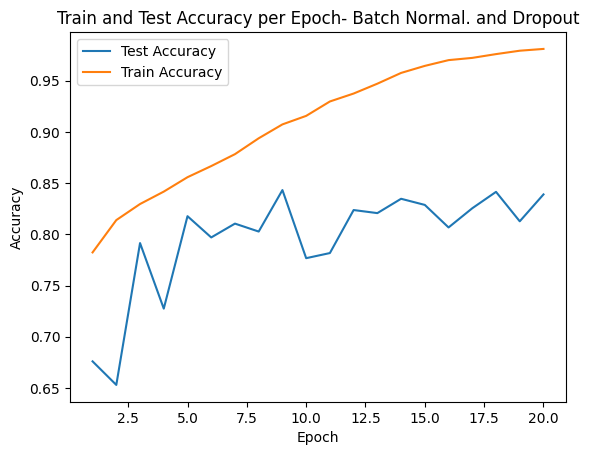

In [ ]:
plot_df = pd.DataFrame({'Test Loss': test_eval_callback.test_loss, 'Test Accuracy': test_eval_callback.test_accuracy,
                        'Train Loss': model_dropout.history.history['loss'], 'Train Accuracy': model_dropout.history.history['acc'],
                        'Epoch': range(1, len(test_eval_callback.test_loss) + 1)})


print(plot_df["Test Loss"].min())
plt.figure()
plt.plot(plot_df["Epoch"], plot_df["Test Loss"], label="Test Loss")
plt.plot(plot_df["Epoch"], plot_df["Train Loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss per Epoch- Batch Normal. and Dropout")
plt.legend()
plt.show()

print(plot_df["Test Accuracy"].max())
plt.figure()
plt.plot(plot_df["Epoch"], plot_df["Test Accuracy"], label="Test Accuracy")
plt.plot(plot_df["Epoch"], plot_df["Train Accuracy"], label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy per Epoch- Batch Normal. and Dropout")
plt.legend()
plt.show()


Based on the max accuracy and min loss for the test data, the addition of the dropout layer did improve things slightly. Again the test accuracy and loss seem to be optimal at an earlier epoch than 20.

In [ ]:
model_dropout.save('/content/drive/MyDrive/Colab Notebooks/cnn_model_dropout.keras')

## Model Tuning 3- Attempt Padding with less CNN Layers

One last thing I'll try to further address overfitting is to reduce the amount of "Conv2d -> Conv2d -> MaxPooling" layers from 3 to 2.

In [ ]:
model_padding = models.Sequential()
model_padding.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                        input_shape=(96, 96, 3)))
model_padding.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model_padding.add(layers.MaxPooling2D((2, 2)))
model_padding.add(layers.BatchNormalization())
model_padding.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_padding.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model_padding.add(layers.MaxPooling2D((2, 2)))
model_padding.add(layers.BatchNormalization())
model_padding.add(layers.Dropout(0.2))
model_padding.add(layers.Flatten())
model_padding.add(layers.Dense(512, activation='relu'))
model_padding.add(layers.Dense(1, activation='sigmoid'))

model_padding.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_78 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 96, 96, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 48, 48, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,734,529 (18.06 MB)

 Trainable params: 4,734,465 (18.06 MB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
model_padding.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adamax(),
              metrics=['acc'])


In [ ]:
test_eval_callback = TestSetEvaluation(X_test, y_test)
model_padding.fit(X_train, y_train, epochs=20, callbacks=[test_eval_callback])


Epoch 1/20
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.7486 - loss: 0.7688
Epoch 1: Test Loss: 0.5061, Test Accuracy: 0.7765
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - acc: 0.7487 - loss: 0.7678
Epoch 2/20
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.8476 - loss: 0.3483
Epoch 2: Test Loss: 0.4352, Test Accuracy: 0.8123
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - acc: 0.8475 - loss: 0.3483
Epoch 3/20
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9055 - loss: 0.2461
Epoch 3: Test Loss: 0.4712, Test Accuracy: 0.8115
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - acc: 0.9055 - loss: 0.2462
Epoch 4/20
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9462 - loss: 0.1515
Epoch 4: Test Loss: 0.9171, Test Accuracy: 0.7315
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - acc: 0.9462 - loss: 0.1515
Epoch 5/20
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9715 - loss: 0.0902
Epoch 5: Test Loss: 0.5694, Test Accuracy: 0.8148
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - acc: 0.9715 - lo

0.435234934091568


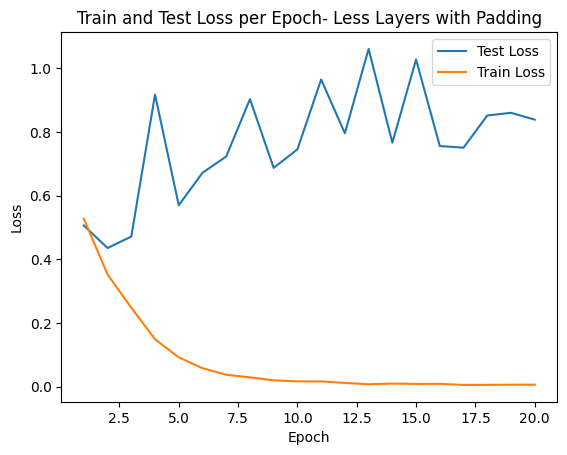

0.8174999952316284


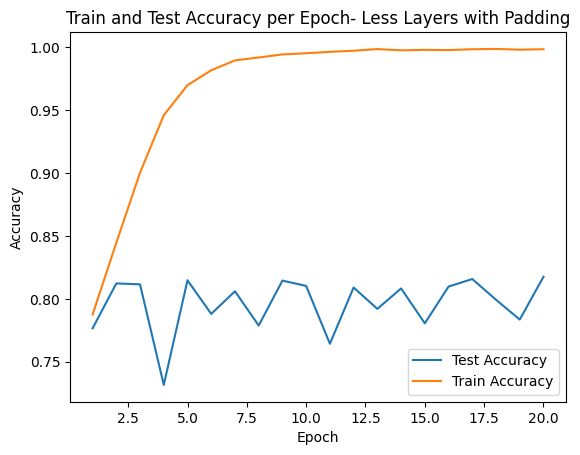

In [ ]:
plot_df = pd.DataFrame({'Test Loss': test_eval_callback.test_loss, 'Test Accuracy': test_eval_callback.test_accuracy,
                        'Train Loss': model_padding.history.history['loss'], 'Train Accuracy': model_padding.history.history['acc'],
                        'Epoch': range(1, len(test_eval_callback.test_loss) + 1)})


print(plot_df["Test Loss"].min())
plt.figure()
plt.plot(plot_df["Epoch"], plot_df["Test Loss"], label="Test Loss")
plt.plot(plot_df["Epoch"], plot_df["Train Loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss per Epoch- Less Layers with Padding")
plt.legend()
plt.show()

print(plot_df["Test Accuracy"].max())
plt.figure()
plt.plot(plot_df["Epoch"], plot_df["Test Accuracy"], label="Test Accuracy")
plt.plot(plot_df["Epoch"], plot_df["Train Accuracy"], label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy per Epoch- Less Layers with Padding")
plt.legend()
plt.show()



This seems to be the worst model of the few I tried, suggesting the original architecture performed better. If I had additional time, it may have been worth exploring adding additional convolutional layers to the CNN model.

## Create Optimal Model Based on Analysis Above

### 3 CNN Layers with Batch Normilization and a Dropout Layer Between the CNN and Dense Layer

In [ ]:
model_opt = models.Sequential()
model_opt.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(96, 96, 3)))
model_opt.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_opt.add(layers.MaxPooling2D((2, 2)))
model_opt.add(layers.BatchNormalization())
model_opt.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_opt.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_opt.add(layers.MaxPooling2D((2, 2)))
model_opt.add(layers.BatchNormalization())
model_opt.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_opt.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_opt.add(layers.MaxPooling2D((2, 2)))
model_opt.add(layers.BatchNormalization())
model_opt.add(layers.Dropout(0.2))
model_opt.add(layers.Flatten())
model_opt.add(layers.Dense(512, activation='relu'))
model_opt.add(layers.Dense(1, activation='sigmoid'))

model_opt.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_82 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 92, 92, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 46, 46, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 46, 46, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 44, 44, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 42, 42, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 21, 21, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 21, 21, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 19, 19, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 17, 17, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,553 (2.10 MB)

 Trainable params: 549,457 (2.10 MB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
model_opt.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adamax(),
              metrics=['acc'])

Setting epochs to 8 based to maximize test accuracy based on analysis above

In [ ]:
test_eval_callback = TestSetEvaluation(X_test, y_test)
model_opt.fit(X_train, y_train, epochs=7, callbacks=[test_eval_callback])


Epoch 1/7
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9808 - loss: 0.0622
Epoch 1: Test Loss: 0.6683, Test Accuracy: 0.8145
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.9808 - loss: 0.0622
Epoch 2/7
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9831 - loss: 0.0562
Epoch 2: Test Loss: 0.5840, Test Accuracy: 0.8338
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.9831 - loss: 0.0562
Epoch 3/7
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9840 - loss: 0.0536
Epoch 3: Test Loss: 0.5946, Test Accuracy: 0.8215
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.9840 - loss: 0.0536
Epoch 4/7
495/500 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9844 - loss: 0.0498
Epoch 4: Test Loss: 0.6414, Test Accuracy: 0.8282
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - acc: 0.9843 - loss: 0.0498
Epoch 5/7
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9817 - loss: 0.0513
Epoch 5: Test Loss: 0.6264, Test Accuracy: 0.8275
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.9817 - loss: 0.

In [ ]:
model_opt.save('/content/drive/MyDrive/Colab Notebooks/cnn_model_optimal.keras')

## Prepare Kaggle Submission

In [ ]:
import os

test_file_path = "/content/drive/MyDrive/Colab Notebooks/test/"
all_entries = os.listdir(test_file_path)
entry_number = [entry.split(".")[0].split("_")[-1] for entry in all_entries]
entry_number = list(set(entry_number))
entry_number.remove('')
print(entry_number)


['13000', '27000', '43000', '34000', '39000', '55000', '19000', '37000', '56000', '50000', '11000', '40000', '49000', '57000', '9000', '38000', '8000', '15000', '1000', '48000', '22000', '7000', '45000', '18000', '24000', '5000', '46000', '41000', '57458', '47000', '35000', '53000', '10000', '26000', '12000', '3000', '28000', '54000', '4000', '23000', '51000', '25000', '14000', '33000', '44000', '17000', '2000', '20000', '21000', '6000', '52000', '16000', '42000', '30000', '31000', '36000', '32000', '29000']


In [ ]:
opt_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/cnn_model_optimal.keras')


In [ ]:

overall_df = pd.DataFrame()

# first_df = True
for batch in entry_number:
# batch = '13000'
  X_test_csv = test_file_path + "test_" + batch + ".csv"
  X_test_df = pd.read_csv(X_test_csv, header=None)
  X_test = np.array(X_test_df)
  X_test = X_test.reshape(-1, 96, 96, 3)

  ids_csv = test_file_path + "test_labels_" + batch + ".csv"
  batch_df = pd.read_csv(ids_csv, header=None)
  batch_df = batch_df.rename(columns={0: "id"})

  y_pred_proba = opt_model.predict(X_test)
  # Apply a threshold to get binary predictions
  y_test_binary = (y_pred_proba >= 0.5).astype(int)
  y_test_binary = y_test_binary.reshape(1, -1)[0]
  batch_df['label'] = y_test_binary
  overall_df = pd.concat([overall_df, batch_df])

print(len(overall_df))
overall_df.head()



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━

,id,label
0,d4b4570a06b3f045e1ac54c35a404d3bc305d4b4,0
1,facd94891ea085999818f52910fcbc2b3b15f5e3,1
2,4b7d928679465f2ac97117f4456fa2cf5b2e68f6,1
3,bf84cad715a06025b416dd8b30812ec6ae08f193,0
4,d2eb7b2d30128713d66b1661ccab051e25e1c8ba,0


In [ ]:
overall_df.to_csv('/content/drive/MyDrive/Colab Notebooks/submission.csv', index=False)

## Kaggle Submission Score- 0.7794

# Conclusion

To conclude, adding batch normalization and dropout layers helped address some of the overfitting problems in the first CNN model and improved the generalizability. Reducing the number of CNN layers used in the model architecture had a negative impact on the performance.

If I had some time, here's some things I'd do to improve the performance of the model:


*   Increase the train data size if a higher capacity GPU is available
*   Train on multiple batches of train data subsets

*   If using subsets of the training data, ensure a 50-50 split between the two classes in the response (a 60-40 split was used above)
*   Additional hyperparameter tuning (for example, increasing the number of CNN layers, or introducing padding or strides if using a larger train data set)








### Sources

* https://stackoverflow.com/questions/72013197/evaluate-model-on-testing-set-after-each-epoch-of-training